In [ ]:
import sympy
sympy.init_printing()
from sympy.abc import x,phi,v,g,k
import matplotlib.style
matplotlib.style.use('ggplot')
pi=sympy.pi

In [ ]:
eq=1/(2*pi)-1/(2*pi*v)*sympy.sin(phi)

In [ ]:
sympy.solve(sympy.Eq(eq,0),v)

In [ ]:
b=sympy.asin(.2)
b

In [ ]:
bb=sympy.integrate(eq,(phi,pi-g,2*pi+g))
bb

In [ ]:
bb.subs(g,sympy.asin(v)).subs(v,1).evalf()

In [ ]:
%matplotlib notebook
sympy.plot(2*pi*eq.subs(v,.9),(phi,0,2*pi))

In [ ]:
sympy.limit(x*sympy.log(x)/x,x,.1)

<IPython.core.display.Javascript object>


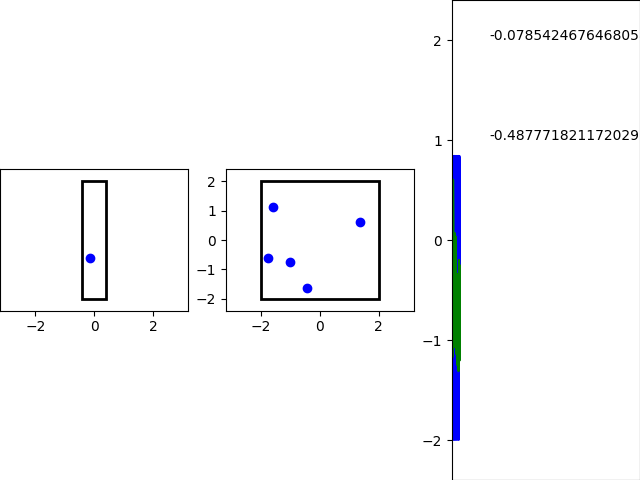

In [10]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
# Extend
# http://www.mate.tue.nl/mate/pdfs/12804.pdf

%matplotlib notebook
import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + 0*self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - 0*self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + 0*self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - 0*self.size)

        self.state[crossed_x1, 0] = 2*self.bounds[0] - self.state[crossed_x1, 0] # + 0*self.size
        self.state[crossed_x2, 0] = 2*self.bounds[1] - self.state[crossed_x2, 0] #0*self.size

        self.state[crossed_y1, 1] = 2*self.bounds[2] - self.state[crossed_y1, 1]#+ 0*self.size
        self.state[crossed_y2, 1] = 2*self.bounds[3] - self.state[crossed_y2, 1]#- 0*self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = -0.5 + np.random.random((1, 4))
init_state[:, :2] *= 3.9
np.random.seed(0)
init_state2 = -0.5 + np.random.random((5, 4))
init_state2[:, :2] *= 3.9

box = ParticleBox(init_state, bounds = [-.4, .4, -2, 2],size=0.1)
box2 = ParticleBox(init_state2, bounds = [-2, 2, -2, 2],size=0.1)
dt = 1. / 300 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(131, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))
ax2 = fig.add_subplot(132, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))
ax3 = fig.add_subplot(133,xlim=(0, 1000), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)
particles2, = ax2.plot([], [], 'bo', ms=6)
avg_line, = ax3.plot([],[],'b')
avg_line2, = ax3.plot([],[],'g')
avg_text  = ax3.text(200,2,str(0))
avg_text2  = ax3.text(200,1,str(0))
avg=[]
avg2=[]
tt=[]

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

rect2 = plt.Rectangle(box2.bounds[::2],
                     box2.bounds[1] - box2.bounds[0],
                     box2.bounds[3] - box2.bounds[2],
                     ec='none', lw=2, fc='none')
ax2.add_patch(rect2)


def init():
    """initialize animation"""
    global box, rect,avg_line,avg_text,rect2,avg_text,avg_text2
    particles.set_data([], [])
    rect.set_edgecolor('none')
    rect2.set_edgecolor('none')
    avg_line.set_data([],[])
    avg_line2.set_data([],[])
    return particles, rect ,particles2,rect2,avg_line,avg_line2,avg_text,avg_text2

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig,avg_line,avg_text, rect2,avg_text,avg_text2
    for _ in range(10):
        box.step(dt)
        box2.step(dt)
        avg.append(np.mean(box.state[:, 1]))
        avg2.append(np.mean(box2.state[:, 1]))
        if len(tt)==0:
            tt.append(dt)
        else:
            tt.append(tt[-1]+dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    ms=6
    # update pieces of the animation
    rect.set_edgecolor('k')
    rect2.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles2.set_data(box2.state[:, 0], box2.state[:, 1])
    
    avgv=np.mean(avg)
    avgv2=np.mean(avg2)
    avg_line.set_data(tt,avg)
    avg_line2.set_data(tt,avg2)
    avg_text.set_text(str(avgv))
    avg_text2.set_text(str(avgv2))
    particles.set_markersize(ms)
    particles2.set_markersize(ms)
    return particles, rect ,particles2,rect2,avg_line,avg_line2,avg_text,avg_text2

ani = animation.FuncAnimation(fig, animate, frames=600,
                              interval=1, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('particle_box.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
#pause
ani.event_source.stop()

In [ ]:
#unpause
ani.event_source.start()

In [ ]:
ax.set_ylim(-2.4,2.4)

In [ ]:
%matplotlib notebook
plt.plot(tt,avg)
plt.plot(tt,avg2)

In [ ]:
np.mean(avg[-400:])

In [ ]:
np.mean(avg2[-400:])